# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './input'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

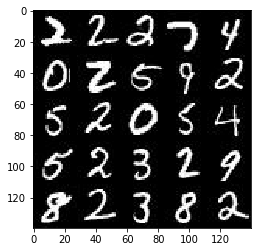

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

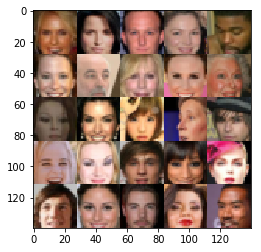

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.1
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, (None, image_height, image_width, image_channels))
    inputs_z = tf.placeholder(tf.float32, (None, z_dim))
    learning_rate = tf.placeholder(tf.float32)
    
    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [23]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.1
    k_initializer = tf.random_normal_initializer(stddev=0.02)
    
    with tf.variable_scope('discriminator', reuse=reuse):
#         input 28x28x?
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, kernel_initializer=k_initializer, padding='same')
        x1 = tf.maximum(x1, alpha * x1)
#         14x14x64

        x2 = tf.layers.conv2d(x1, 128, 5, strides=2, kernel_initializer=k_initializer, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=True)
        x2 = tf.maximum(x2, alpha * x2)
#         7x7x128

        x3 = tf.layers.conv2d(x2, 256, 5, strides=1, kernel_initializer=k_initializer, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=True)
        x3 = tf.maximum(x3, alpha * x3)
#         7x7x256 

        flat = tf.contrib.layers.flatten(x3)
        logits = tf.layers.dense(flat, 1)        
        
        out = tf.sigmoid(logits)
        

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [22]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.1
    k_initializer = tf.random_normal_initializer(stddev=0.02)
    
    with tf.variable_scope('generator', reuse=not is_train):
        x1 = tf.layers.dense(z, 7 * 7 * 512, activation=None)
        
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(x1, alpha * x1)
#         7x7x512

        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=1, kernel_initializer=k_initializer, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(x2, alpha * x2)
#         7x7x256
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, kernel_initializer=k_initializer, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(x3, alpha * x3)
#         14x14x128

        x4 = tf.layers.conv2d_transpose(x3, 64, 5, strides=2, kernel_initializer=k_initializer, padding='same')
        x4 = tf.layers.batch_normalization(x4, training=is_train)
        x4 = tf.maximum(x4, alpha * x4)
#         28x28x64

#         28x28x out_channel_dim
        logits = tf.layers.conv2d_transpose(x4, out_channel_dim, 5, strides=1, kernel_initializer=k_initializer, padding='same')
        
        out = tf.tanh(logits)
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [16]:
import numpy as np

def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real) * np.random.uniform(0.7, 1.2)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake) * np.random.uniform(0.0, 0.3)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [17]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [18]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [24]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z,  data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    saver = tf.train.Saver()
    sample_z = np.random.uniform(-1, 1, size=(72, z_dim))
    
    steps = 0

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                
#               batch_images *=2 for matching generator
                batch_images *= 2                                                
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images, lr: learning_rate})

                if steps % 10 == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % 100 == 0:
                    show_generator_output(sess, 25, input_z, data_shape[3], data_image_mode)

                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 4.1508... Generator Loss: 5.0260
Epoch 1/2... Discriminator Loss: 2.9462... Generator Loss: 2.9056
Epoch 1/2... Discriminator Loss: 2.3986... Generator Loss: 2.0382
Epoch 1/2... Discriminator Loss: 2.0110... Generator Loss: 1.4807
Epoch 1/2... Discriminator Loss: 2.4119... Generator Loss: 1.6259
Epoch 1/2... Discriminator Loss: 2.1266... Generator Loss: 1.8361
Epoch 1/2... Discriminator Loss: 1.7366... Generator Loss: 1.1000
Epoch 1/2... Discriminator Loss: 1.8471... Generator Loss: 1.4275
Epoch 1/2... Discriminator Loss: 1.5855... Generator Loss: 1.1910
Epoch 1/2... Discriminator Loss: 1.7633... Generator Loss: 1.3598


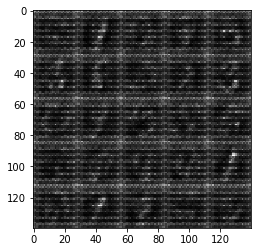

Epoch 1/2... Discriminator Loss: 1.9417... Generator Loss: 1.6853
Epoch 1/2... Discriminator Loss: 1.7814... Generator Loss: 1.7932
Epoch 1/2... Discriminator Loss: 1.6653... Generator Loss: 1.1363
Epoch 1/2... Discriminator Loss: 1.7246... Generator Loss: 1.8337
Epoch 1/2... Discriminator Loss: 1.6962... Generator Loss: 1.7570
Epoch 1/2... Discriminator Loss: 1.6492... Generator Loss: 1.4805
Epoch 1/2... Discriminator Loss: 1.5756... Generator Loss: 1.6122
Epoch 1/2... Discriminator Loss: 1.6942... Generator Loss: 1.6453
Epoch 1/2... Discriminator Loss: 1.6627... Generator Loss: 1.3737
Epoch 1/2... Discriminator Loss: 1.6658... Generator Loss: 1.5540


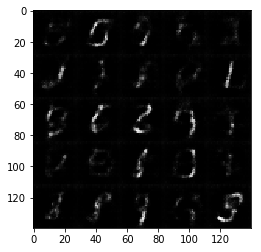

Epoch 1/2... Discriminator Loss: 1.5653... Generator Loss: 1.3705
Epoch 1/2... Discriminator Loss: 1.4596... Generator Loss: 1.3643
Epoch 1/2... Discriminator Loss: 1.6342... Generator Loss: 1.5523
Epoch 1/2... Discriminator Loss: 1.6891... Generator Loss: 1.7654
Epoch 1/2... Discriminator Loss: 1.7176... Generator Loss: 1.5606
Epoch 1/2... Discriminator Loss: 1.5428... Generator Loss: 1.5388
Epoch 1/2... Discriminator Loss: 1.6543... Generator Loss: 1.8677
Epoch 1/2... Discriminator Loss: 1.6991... Generator Loss: 1.8949
Epoch 1/2... Discriminator Loss: 1.4702... Generator Loss: 1.3600
Epoch 1/2... Discriminator Loss: 1.4854... Generator Loss: 1.4406


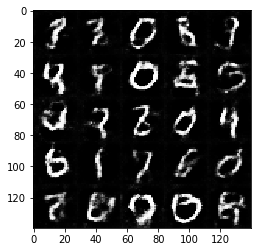

Epoch 1/2... Discriminator Loss: 1.3376... Generator Loss: 1.0371
Epoch 1/2... Discriminator Loss: 1.6532... Generator Loss: 1.7011
Epoch 1/2... Discriminator Loss: 1.4875... Generator Loss: 1.3872
Epoch 1/2... Discriminator Loss: 1.5413... Generator Loss: 1.5609
Epoch 1/2... Discriminator Loss: 1.5355... Generator Loss: 1.5150
Epoch 1/2... Discriminator Loss: 1.5790... Generator Loss: 1.6405
Epoch 1/2... Discriminator Loss: 1.4127... Generator Loss: 1.1182
Epoch 1/2... Discriminator Loss: 1.4489... Generator Loss: 1.5066
Epoch 1/2... Discriminator Loss: 1.4938... Generator Loss: 1.4177
Epoch 1/2... Discriminator Loss: 1.3799... Generator Loss: 1.6113


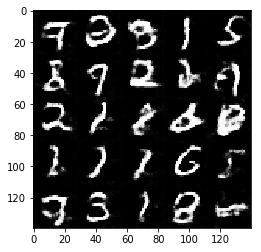

Epoch 1/2... Discriminator Loss: 1.5629... Generator Loss: 1.7780
Epoch 1/2... Discriminator Loss: 1.5442... Generator Loss: 1.6066
Epoch 1/2... Discriminator Loss: 1.5476... Generator Loss: 1.7497
Epoch 1/2... Discriminator Loss: 1.4895... Generator Loss: 1.7946
Epoch 1/2... Discriminator Loss: 1.5051... Generator Loss: 1.6828
Epoch 1/2... Discriminator Loss: 1.5314... Generator Loss: 1.5145
Epoch 1/2... Discriminator Loss: 1.3869... Generator Loss: 1.3941
Epoch 1/2... Discriminator Loss: 1.4087... Generator Loss: 1.4636
Epoch 1/2... Discriminator Loss: 1.5941... Generator Loss: 1.7505
Epoch 1/2... Discriminator Loss: 1.5712... Generator Loss: 1.6327


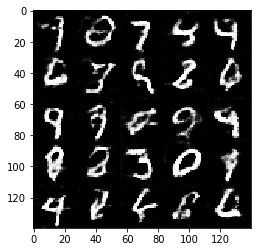

Epoch 1/2... Discriminator Loss: 1.4840... Generator Loss: 1.6647
Epoch 1/2... Discriminator Loss: 1.6816... Generator Loss: 1.8209
Epoch 1/2... Discriminator Loss: 1.3959... Generator Loss: 0.9626
Epoch 1/2... Discriminator Loss: 1.3181... Generator Loss: 1.2635
Epoch 1/2... Discriminator Loss: 1.4653... Generator Loss: 1.5862
Epoch 1/2... Discriminator Loss: 1.4052... Generator Loss: 1.3247
Epoch 1/2... Discriminator Loss: 1.5199... Generator Loss: 1.5370
Epoch 1/2... Discriminator Loss: 1.4941... Generator Loss: 1.7134
Epoch 1/2... Discriminator Loss: 1.2972... Generator Loss: 1.2342
Epoch 1/2... Discriminator Loss: 1.7596... Generator Loss: 1.9223


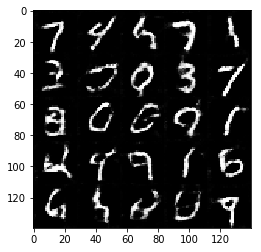

Epoch 1/2... Discriminator Loss: 1.4141... Generator Loss: 1.4625
Epoch 1/2... Discriminator Loss: 1.5086... Generator Loss: 1.3999
Epoch 1/2... Discriminator Loss: 1.8220... Generator Loss: 2.1282
Epoch 1/2... Discriminator Loss: 1.3151... Generator Loss: 1.0124
Epoch 1/2... Discriminator Loss: 1.5027... Generator Loss: 0.5053
Epoch 1/2... Discriminator Loss: 1.5530... Generator Loss: 0.4984
Epoch 1/2... Discriminator Loss: 1.6256... Generator Loss: 0.4325
Epoch 1/2... Discriminator Loss: 1.5618... Generator Loss: 0.4794
Epoch 1/2... Discriminator Loss: 1.8362... Generator Loss: 0.3323
Epoch 1/2... Discriminator Loss: 1.7091... Generator Loss: 0.3847


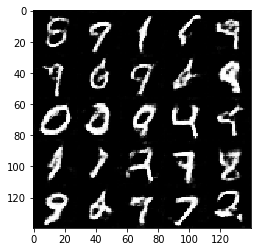

Epoch 1/2... Discriminator Loss: 1.4659... Generator Loss: 0.5716
Epoch 1/2... Discriminator Loss: 1.5325... Generator Loss: 0.5039
Epoch 1/2... Discriminator Loss: 1.9650... Generator Loss: 0.2919
Epoch 1/2... Discriminator Loss: 1.3476... Generator Loss: 0.6962
Epoch 1/2... Discriminator Loss: 1.5634... Generator Loss: 0.4692
Epoch 1/2... Discriminator Loss: 1.7240... Generator Loss: 0.3893
Epoch 1/2... Discriminator Loss: 1.4790... Generator Loss: 0.5488
Epoch 1/2... Discriminator Loss: 1.5756... Generator Loss: 0.4538
Epoch 1/2... Discriminator Loss: 1.3678... Generator Loss: 0.6802
Epoch 1/2... Discriminator Loss: 1.3113... Generator Loss: 0.7439


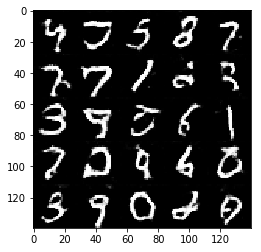

Epoch 1/2... Discriminator Loss: 1.7554... Generator Loss: 0.3912
Epoch 1/2... Discriminator Loss: 1.5120... Generator Loss: 0.5130
Epoch 1/2... Discriminator Loss: 1.4063... Generator Loss: 0.5988
Epoch 1/2... Discriminator Loss: 1.5097... Generator Loss: 0.5117
Epoch 1/2... Discriminator Loss: 1.7395... Generator Loss: 0.3946
Epoch 1/2... Discriminator Loss: 1.5202... Generator Loss: 0.5048
Epoch 1/2... Discriminator Loss: 1.4427... Generator Loss: 0.5511
Epoch 1/2... Discriminator Loss: 1.4697... Generator Loss: 0.5701
Epoch 1/2... Discriminator Loss: 1.5387... Generator Loss: 0.4726
Epoch 1/2... Discriminator Loss: 1.4902... Generator Loss: 0.5286


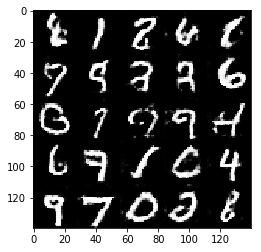

Epoch 1/2... Discriminator Loss: 1.5849... Generator Loss: 0.4754
Epoch 1/2... Discriminator Loss: 1.5041... Generator Loss: 0.5242
Epoch 1/2... Discriminator Loss: 1.4759... Generator Loss: 0.5433
Epoch 2/2... Discriminator Loss: 1.5435... Generator Loss: 0.5078
Epoch 2/2... Discriminator Loss: 1.3617... Generator Loss: 0.6299
Epoch 2/2... Discriminator Loss: 1.4530... Generator Loss: 0.5846
Epoch 2/2... Discriminator Loss: 1.4737... Generator Loss: 0.5322
Epoch 2/2... Discriminator Loss: 1.3908... Generator Loss: 0.6919
Epoch 2/2... Discriminator Loss: 1.4241... Generator Loss: 0.5653
Epoch 2/2... Discriminator Loss: 1.5510... Generator Loss: 0.4907


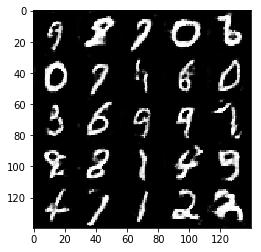

Epoch 2/2... Discriminator Loss: 1.6363... Generator Loss: 0.4256
Epoch 2/2... Discriminator Loss: 1.5555... Generator Loss: 0.4821
Epoch 2/2... Discriminator Loss: 1.4839... Generator Loss: 0.5084
Epoch 2/2... Discriminator Loss: 1.5116... Generator Loss: 0.5196
Epoch 2/2... Discriminator Loss: 1.6516... Generator Loss: 0.4460
Epoch 2/2... Discriminator Loss: 1.3199... Generator Loss: 0.6949
Epoch 2/2... Discriminator Loss: 1.3639... Generator Loss: 0.6009
Epoch 2/2... Discriminator Loss: 1.5655... Generator Loss: 0.4864
Epoch 2/2... Discriminator Loss: 1.3714... Generator Loss: 0.6375
Epoch 2/2... Discriminator Loss: 1.4404... Generator Loss: 0.5910


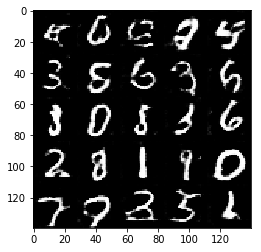

Epoch 2/2... Discriminator Loss: 1.4026... Generator Loss: 0.6227
Epoch 2/2... Discriminator Loss: 1.4414... Generator Loss: 0.5644
Epoch 2/2... Discriminator Loss: 1.4208... Generator Loss: 0.6085
Epoch 2/2... Discriminator Loss: 1.4941... Generator Loss: 0.5222
Epoch 2/2... Discriminator Loss: 1.3736... Generator Loss: 0.6022
Epoch 2/2... Discriminator Loss: 1.4985... Generator Loss: 0.4987
Epoch 2/2... Discriminator Loss: 1.3625... Generator Loss: 0.6255
Epoch 2/2... Discriminator Loss: 1.3243... Generator Loss: 0.6599
Epoch 2/2... Discriminator Loss: 1.4252... Generator Loss: 0.5675
Epoch 2/2... Discriminator Loss: 1.7136... Generator Loss: 0.4013


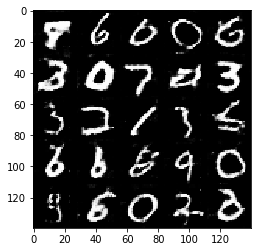

Epoch 2/2... Discriminator Loss: 1.5463... Generator Loss: 0.4999
Epoch 2/2... Discriminator Loss: 1.5206... Generator Loss: 0.4947
Epoch 2/2... Discriminator Loss: 1.4794... Generator Loss: 0.5425
Epoch 2/2... Discriminator Loss: 1.6230... Generator Loss: 0.4921
Epoch 2/2... Discriminator Loss: 1.3255... Generator Loss: 0.6950
Epoch 2/2... Discriminator Loss: 1.2300... Generator Loss: 0.8507
Epoch 2/2... Discriminator Loss: 1.3692... Generator Loss: 1.1718
Epoch 2/2... Discriminator Loss: 1.3200... Generator Loss: 1.5535
Epoch 2/2... Discriminator Loss: 1.1994... Generator Loss: 1.0736
Epoch 2/2... Discriminator Loss: 1.2715... Generator Loss: 1.3409


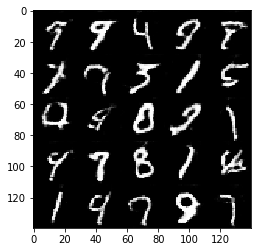

Epoch 2/2... Discriminator Loss: 1.4309... Generator Loss: 1.8108
Epoch 2/2... Discriminator Loss: 1.3070... Generator Loss: 1.1704
Epoch 2/2... Discriminator Loss: 1.3604... Generator Loss: 1.6433
Epoch 2/2... Discriminator Loss: 1.2641... Generator Loss: 1.6306
Epoch 2/2... Discriminator Loss: 1.4743... Generator Loss: 1.5555
Epoch 2/2... Discriminator Loss: 1.2612... Generator Loss: 1.4590
Epoch 2/2... Discriminator Loss: 1.3901... Generator Loss: 1.6366
Epoch 2/2... Discriminator Loss: 1.2082... Generator Loss: 1.2272
Epoch 2/2... Discriminator Loss: 1.3679... Generator Loss: 1.4826
Epoch 2/2... Discriminator Loss: 1.3894... Generator Loss: 1.9156


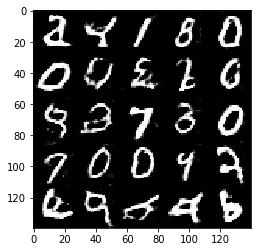

Epoch 2/2... Discriminator Loss: 1.2828... Generator Loss: 1.2858
Epoch 2/2... Discriminator Loss: 1.2098... Generator Loss: 1.1422
Epoch 2/2... Discriminator Loss: 1.5385... Generator Loss: 0.4823
Epoch 2/2... Discriminator Loss: 1.3715... Generator Loss: 0.6284
Epoch 2/2... Discriminator Loss: 1.2054... Generator Loss: 1.0847
Epoch 2/2... Discriminator Loss: 1.4576... Generator Loss: 1.9051
Epoch 2/2... Discriminator Loss: 1.1815... Generator Loss: 1.5577
Epoch 2/2... Discriminator Loss: 1.3911... Generator Loss: 1.6269
Epoch 2/2... Discriminator Loss: 1.4290... Generator Loss: 1.6776
Epoch 2/2... Discriminator Loss: 1.2448... Generator Loss: 1.4145


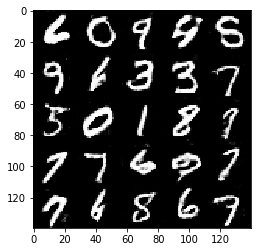

Epoch 2/2... Discriminator Loss: 1.1979... Generator Loss: 1.2359
Epoch 2/2... Discriminator Loss: 1.2651... Generator Loss: 1.2485
Epoch 2/2... Discriminator Loss: 1.5614... Generator Loss: 1.8143
Epoch 2/2... Discriminator Loss: 1.2813... Generator Loss: 1.6200
Epoch 2/2... Discriminator Loss: 1.2572... Generator Loss: 1.4480
Epoch 2/2... Discriminator Loss: 1.6216... Generator Loss: 1.7081
Epoch 2/2... Discriminator Loss: 1.1810... Generator Loss: 1.5186
Epoch 2/2... Discriminator Loss: 1.5401... Generator Loss: 1.9062
Epoch 2/2... Discriminator Loss: 1.3052... Generator Loss: 1.3867
Epoch 2/2... Discriminator Loss: 1.2417... Generator Loss: 1.4684


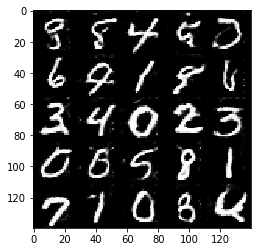

Epoch 2/2... Discriminator Loss: 1.2105... Generator Loss: 1.5205
Epoch 2/2... Discriminator Loss: 1.2245... Generator Loss: 1.4532
Epoch 2/2... Discriminator Loss: 1.2295... Generator Loss: 1.5374
Epoch 2/2... Discriminator Loss: 1.6928... Generator Loss: 1.9448
Epoch 2/2... Discriminator Loss: 1.2387... Generator Loss: 1.3820
Epoch 2/2... Discriminator Loss: 1.1744... Generator Loss: 1.5316
Epoch 2/2... Discriminator Loss: 1.2899... Generator Loss: 1.3779
Epoch 2/2... Discriminator Loss: 1.0967... Generator Loss: 1.3323
Epoch 2/2... Discriminator Loss: 1.4457... Generator Loss: 1.8848
Epoch 2/2... Discriminator Loss: 1.4413... Generator Loss: 1.5602


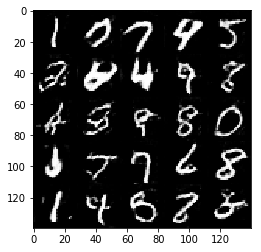

Epoch 2/2... Discriminator Loss: 1.1967... Generator Loss: 1.5145
Epoch 2/2... Discriminator Loss: 1.1947... Generator Loss: 1.4490
Epoch 2/2... Discriminator Loss: 1.2528... Generator Loss: 1.4745
Epoch 2/2... Discriminator Loss: 1.6726... Generator Loss: 2.1380
Epoch 2/2... Discriminator Loss: 1.1082... Generator Loss: 1.0494
Epoch 2/2... Discriminator Loss: 1.4355... Generator Loss: 2.0571
Epoch 2/2... Discriminator Loss: 1.2093... Generator Loss: 1.5746
Epoch 2/2... Discriminator Loss: 1.3333... Generator Loss: 1.7088
Epoch 2/2... Discriminator Loss: 1.1009... Generator Loss: 1.1595
Epoch 2/2... Discriminator Loss: 1.3160... Generator Loss: 1.7903


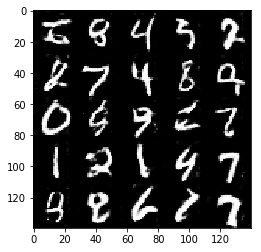

Epoch 2/2... Discriminator Loss: 1.6096... Generator Loss: 1.8260
Epoch 2/2... Discriminator Loss: 1.3845... Generator Loss: 0.6036
Epoch 2/2... Discriminator Loss: 1.3488... Generator Loss: 0.6911
Epoch 2/2... Discriminator Loss: 1.4381... Generator Loss: 0.5470
Epoch 2/2... Discriminator Loss: 1.2881... Generator Loss: 0.7948
Epoch 2/2... Discriminator Loss: 1.4896... Generator Loss: 0.4934
Epoch 2/2... Discriminator Loss: 1.1159... Generator Loss: 1.0402


In [25]:
batch_size = 64
z_dim = 100
learning_rate = 0.0005
beta1 = 0.1


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 5.2068... Generator Loss: 0.0116
Epoch 1/1... Discriminator Loss: 4.6883... Generator Loss: 0.0169
Epoch 1/1... Discriminator Loss: 2.6493... Generator Loss: 0.1579
Epoch 1/1... Discriminator Loss: 2.6169... Generator Loss: 0.1470
Epoch 1/1... Discriminator Loss: 2.3963... Generator Loss: 0.1732
Epoch 1/1... Discriminator Loss: 2.1212... Generator Loss: 0.2304
Epoch 1/1... Discriminator Loss: 2.0082... Generator Loss: 0.3288
Epoch 1/1... Discriminator Loss: 1.9710... Generator Loss: 0.3213
Epoch 1/1... Discriminator Loss: 1.6113... Generator Loss: 0.4237
Epoch 1/1... Discriminator Loss: 1.8917... Generator Loss: 0.3056


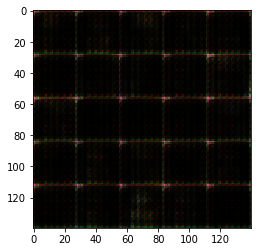

Epoch 1/1... Discriminator Loss: 1.2055... Generator Loss: 0.8702
Epoch 1/1... Discriminator Loss: 1.3750... Generator Loss: 0.4886
Epoch 1/1... Discriminator Loss: 1.7869... Generator Loss: 0.3478
Epoch 1/1... Discriminator Loss: 1.5764... Generator Loss: 0.4078
Epoch 1/1... Discriminator Loss: 1.5171... Generator Loss: 0.4171
Epoch 1/1... Discriminator Loss: 1.6213... Generator Loss: 0.4193
Epoch 1/1... Discriminator Loss: 1.9818... Generator Loss: 0.2458
Epoch 1/1... Discriminator Loss: 1.6581... Generator Loss: 0.3574
Epoch 1/1... Discriminator Loss: 1.5181... Generator Loss: 0.3928
Epoch 1/1... Discriminator Loss: 1.5293... Generator Loss: 0.5163


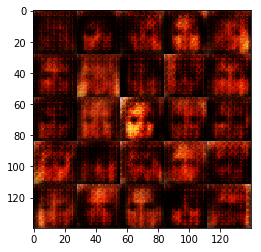

Epoch 1/1... Discriminator Loss: 1.3953... Generator Loss: 0.6124
Epoch 1/1... Discriminator Loss: 1.9344... Generator Loss: 0.3014
Epoch 1/1... Discriminator Loss: 1.3748... Generator Loss: 1.0322
Epoch 1/1... Discriminator Loss: 1.4556... Generator Loss: 1.5223
Epoch 1/1... Discriminator Loss: 1.2468... Generator Loss: 1.5795
Epoch 1/1... Discriminator Loss: 1.0872... Generator Loss: 1.5064
Epoch 1/1... Discriminator Loss: 1.3514... Generator Loss: 0.8989
Epoch 1/1... Discriminator Loss: 1.4766... Generator Loss: 1.1151
Epoch 1/1... Discriminator Loss: 1.4986... Generator Loss: 0.4943
Epoch 1/1... Discriminator Loss: 1.9185... Generator Loss: 1.7902


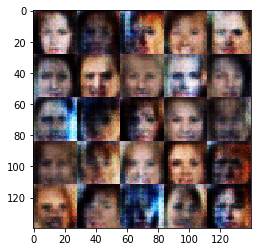

Epoch 1/1... Discriminator Loss: 1.5347... Generator Loss: 0.3903
Epoch 1/1... Discriminator Loss: 1.1847... Generator Loss: 1.1122
Epoch 1/1... Discriminator Loss: 1.7613... Generator Loss: 1.2664
Epoch 1/1... Discriminator Loss: 1.1316... Generator Loss: 1.1042
Epoch 1/1... Discriminator Loss: 1.6140... Generator Loss: 1.1744
Epoch 1/1... Discriminator Loss: 1.4364... Generator Loss: 0.6079
Epoch 1/1... Discriminator Loss: 1.2721... Generator Loss: 0.6398
Epoch 1/1... Discriminator Loss: 1.5587... Generator Loss: 0.4437
Epoch 1/1... Discriminator Loss: 1.4528... Generator Loss: 0.7060
Epoch 1/1... Discriminator Loss: 1.5005... Generator Loss: 0.8072


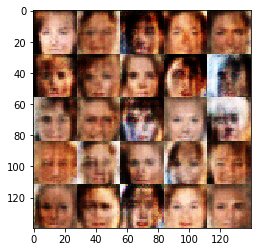

Epoch 1/1... Discriminator Loss: 1.1025... Generator Loss: 1.2123
Epoch 1/1... Discriminator Loss: 1.5397... Generator Loss: 1.2413
Epoch 1/1... Discriminator Loss: 1.4108... Generator Loss: 0.7545
Epoch 1/1... Discriminator Loss: 1.4700... Generator Loss: 1.1288
Epoch 1/1... Discriminator Loss: 1.3128... Generator Loss: 0.8718
Epoch 1/1... Discriminator Loss: 1.5934... Generator Loss: 0.4244
Epoch 1/1... Discriminator Loss: 1.4494... Generator Loss: 0.9660
Epoch 1/1... Discriminator Loss: 1.4656... Generator Loss: 0.4772
Epoch 1/1... Discriminator Loss: 1.3600... Generator Loss: 1.0523
Epoch 1/1... Discriminator Loss: 1.3618... Generator Loss: 0.9250


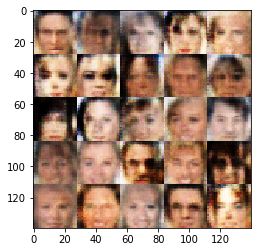

Epoch 1/1... Discriminator Loss: 1.3247... Generator Loss: 0.6794
Epoch 1/1... Discriminator Loss: 1.4236... Generator Loss: 0.6800
Epoch 1/1... Discriminator Loss: 1.5820... Generator Loss: 0.3954
Epoch 1/1... Discriminator Loss: 1.3395... Generator Loss: 0.6952
Epoch 1/1... Discriminator Loss: 1.1907... Generator Loss: 0.7355
Epoch 1/1... Discriminator Loss: 1.4632... Generator Loss: 0.6510
Epoch 1/1... Discriminator Loss: 1.2885... Generator Loss: 0.9452
Epoch 1/1... Discriminator Loss: 1.4694... Generator Loss: 0.8539
Epoch 1/1... Discriminator Loss: 1.2581... Generator Loss: 1.0556
Epoch 1/1... Discriminator Loss: 1.4606... Generator Loss: 0.9682


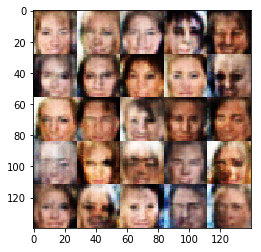

Epoch 1/1... Discriminator Loss: 1.3112... Generator Loss: 0.7117
Epoch 1/1... Discriminator Loss: 1.4321... Generator Loss: 0.6139
Epoch 1/1... Discriminator Loss: 1.3854... Generator Loss: 0.8623
Epoch 1/1... Discriminator Loss: 1.3814... Generator Loss: 0.7815
Epoch 1/1... Discriminator Loss: 1.4886... Generator Loss: 0.6018
Epoch 1/1... Discriminator Loss: 1.3958... Generator Loss: 0.9607
Epoch 1/1... Discriminator Loss: 1.3654... Generator Loss: 0.6571
Epoch 1/1... Discriminator Loss: 1.4714... Generator Loss: 0.5340
Epoch 1/1... Discriminator Loss: 1.6919... Generator Loss: 0.3815
Epoch 1/1... Discriminator Loss: 1.4428... Generator Loss: 1.3027


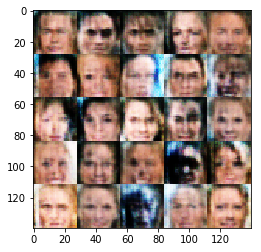

Epoch 1/1... Discriminator Loss: 1.3887... Generator Loss: 0.8903
Epoch 1/1... Discriminator Loss: 1.3838... Generator Loss: 0.8550
Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.7433
Epoch 1/1... Discriminator Loss: 1.3055... Generator Loss: 0.9121
Epoch 1/1... Discriminator Loss: 1.4086... Generator Loss: 0.7413
Epoch 1/1... Discriminator Loss: 1.4060... Generator Loss: 0.6211
Epoch 1/1... Discriminator Loss: 1.5033... Generator Loss: 0.6287
Epoch 1/1... Discriminator Loss: 1.5117... Generator Loss: 0.5114
Epoch 1/1... Discriminator Loss: 1.5148... Generator Loss: 0.5477
Epoch 1/1... Discriminator Loss: 1.4013... Generator Loss: 0.5970


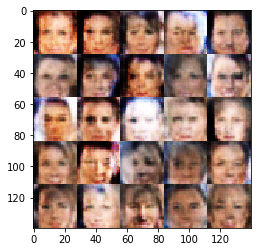

Epoch 1/1... Discriminator Loss: 1.4810... Generator Loss: 0.6037
Epoch 1/1... Discriminator Loss: 1.4061... Generator Loss: 0.7043
Epoch 1/1... Discriminator Loss: 1.3332... Generator Loss: 0.9182
Epoch 1/1... Discriminator Loss: 1.4681... Generator Loss: 1.0244
Epoch 1/1... Discriminator Loss: 1.4406... Generator Loss: 0.5749
Epoch 1/1... Discriminator Loss: 1.3571... Generator Loss: 0.8867
Epoch 1/1... Discriminator Loss: 1.4365... Generator Loss: 1.0496
Epoch 1/1... Discriminator Loss: 1.3919... Generator Loss: 0.8153
Epoch 1/1... Discriminator Loss: 1.4894... Generator Loss: 0.4906
Epoch 1/1... Discriminator Loss: 1.4134... Generator Loss: 0.5878


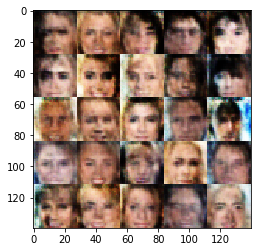

Epoch 1/1... Discriminator Loss: 1.3904... Generator Loss: 0.6957
Epoch 1/1... Discriminator Loss: 1.3338... Generator Loss: 0.9968
Epoch 1/1... Discriminator Loss: 1.5770... Generator Loss: 0.4322
Epoch 1/1... Discriminator Loss: 1.2933... Generator Loss: 0.7747
Epoch 1/1... Discriminator Loss: 1.2969... Generator Loss: 1.3823
Epoch 1/1... Discriminator Loss: 1.3430... Generator Loss: 0.9501
Epoch 1/1... Discriminator Loss: 1.4512... Generator Loss: 0.7808
Epoch 1/1... Discriminator Loss: 1.4088... Generator Loss: 0.7882
Epoch 1/1... Discriminator Loss: 1.5695... Generator Loss: 0.4229
Epoch 1/1... Discriminator Loss: 1.3405... Generator Loss: 0.7215


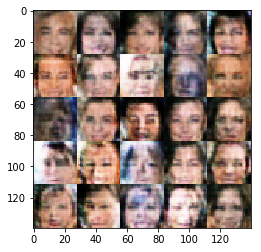

Epoch 1/1... Discriminator Loss: 1.3943... Generator Loss: 1.0508
Epoch 1/1... Discriminator Loss: 1.2840... Generator Loss: 0.9636
Epoch 1/1... Discriminator Loss: 1.2730... Generator Loss: 0.7447
Epoch 1/1... Discriminator Loss: 1.4979... Generator Loss: 1.0492
Epoch 1/1... Discriminator Loss: 1.3674... Generator Loss: 0.6203
Epoch 1/1... Discriminator Loss: 1.3756... Generator Loss: 0.8172
Epoch 1/1... Discriminator Loss: 1.3054... Generator Loss: 1.0399
Epoch 1/1... Discriminator Loss: 1.3845... Generator Loss: 0.8435
Epoch 1/1... Discriminator Loss: 1.3782... Generator Loss: 0.7729
Epoch 1/1... Discriminator Loss: 1.4328... Generator Loss: 0.9254


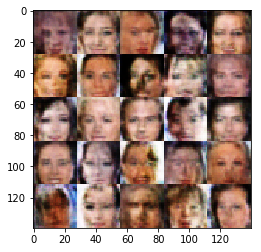

Epoch 1/1... Discriminator Loss: 1.4784... Generator Loss: 0.5447
Epoch 1/1... Discriminator Loss: 1.3954... Generator Loss: 0.6762
Epoch 1/1... Discriminator Loss: 1.3753... Generator Loss: 1.1475
Epoch 1/1... Discriminator Loss: 1.3020... Generator Loss: 0.9061
Epoch 1/1... Discriminator Loss: 1.3397... Generator Loss: 0.7745
Epoch 1/1... Discriminator Loss: 1.3554... Generator Loss: 0.5630
Epoch 1/1... Discriminator Loss: 1.3995... Generator Loss: 0.7631
Epoch 1/1... Discriminator Loss: 1.4032... Generator Loss: 1.0692
Epoch 1/1... Discriminator Loss: 1.6059... Generator Loss: 0.5320
Epoch 1/1... Discriminator Loss: 1.3872... Generator Loss: 0.7468


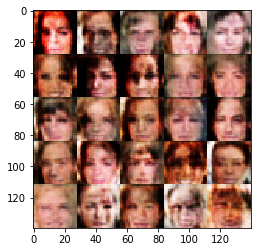

Epoch 1/1... Discriminator Loss: 1.3836... Generator Loss: 0.7809
Epoch 1/1... Discriminator Loss: 1.2083... Generator Loss: 0.7756
Epoch 1/1... Discriminator Loss: 1.4679... Generator Loss: 0.7830
Epoch 1/1... Discriminator Loss: 1.4125... Generator Loss: 0.6335
Epoch 1/1... Discriminator Loss: 1.3679... Generator Loss: 0.6601
Epoch 1/1... Discriminator Loss: 1.3684... Generator Loss: 0.7963
Epoch 1/1... Discriminator Loss: 1.6344... Generator Loss: 0.3358
Epoch 1/1... Discriminator Loss: 1.5659... Generator Loss: 0.4023
Epoch 1/1... Discriminator Loss: 1.4402... Generator Loss: 0.8466
Epoch 1/1... Discriminator Loss: 1.3215... Generator Loss: 0.8138


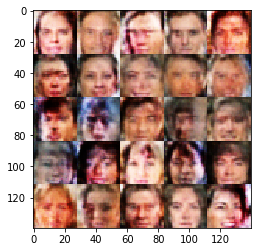

Epoch 1/1... Discriminator Loss: 1.3616... Generator Loss: 0.9390
Epoch 1/1... Discriminator Loss: 1.4192... Generator Loss: 0.7209
Epoch 1/1... Discriminator Loss: 1.3483... Generator Loss: 0.8954
Epoch 1/1... Discriminator Loss: 0.9000... Generator Loss: 0.9632
Epoch 1/1... Discriminator Loss: 0.9013... Generator Loss: 1.4096
Epoch 1/1... Discriminator Loss: 1.2442... Generator Loss: 1.1481
Epoch 1/1... Discriminator Loss: 1.5152... Generator Loss: 0.4968
Epoch 1/1... Discriminator Loss: 1.5466... Generator Loss: 0.3985
Epoch 1/1... Discriminator Loss: 1.9786... Generator Loss: 0.2502
Epoch 1/1... Discriminator Loss: 1.3727... Generator Loss: 0.9652


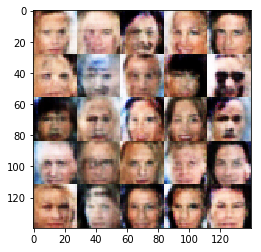

Epoch 1/1... Discriminator Loss: 1.3370... Generator Loss: 0.6481
Epoch 1/1... Discriminator Loss: 1.2951... Generator Loss: 0.7441
Epoch 1/1... Discriminator Loss: 1.3706... Generator Loss: 0.6564
Epoch 1/1... Discriminator Loss: 1.2654... Generator Loss: 0.9121
Epoch 1/1... Discriminator Loss: 1.1763... Generator Loss: 0.8466
Epoch 1/1... Discriminator Loss: 1.3115... Generator Loss: 0.9310
Epoch 1/1... Discriminator Loss: 1.2904... Generator Loss: 1.0266
Epoch 1/1... Discriminator Loss: 1.4640... Generator Loss: 0.5257
Epoch 1/1... Discriminator Loss: 1.3909... Generator Loss: 0.8758
Epoch 1/1... Discriminator Loss: 1.9723... Generator Loss: 1.5543


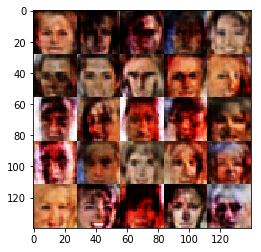

Epoch 1/1... Discriminator Loss: 1.3754... Generator Loss: 0.8848
Epoch 1/1... Discriminator Loss: 1.3733... Generator Loss: 0.9661
Epoch 1/1... Discriminator Loss: 1.4395... Generator Loss: 0.4905
Epoch 1/1... Discriminator Loss: 1.3026... Generator Loss: 0.8114
Epoch 1/1... Discriminator Loss: 1.3373... Generator Loss: 0.6646
Epoch 1/1... Discriminator Loss: 1.2991... Generator Loss: 0.7449
Epoch 1/1... Discriminator Loss: 1.3652... Generator Loss: 0.9498
Epoch 1/1... Discriminator Loss: 1.3091... Generator Loss: 0.9148


In [26]:
batch_size = 128
z_dim = 100
learning_rate = 0.0003
beta1 = 0.1


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.